In [1]:
import numpy as np
import pandas as pd
# import re
from os.path import join

from tools import *

# from sklearn.decomposition import LatentDirichletAllocation
# from scipy.spatial import distance

# import matplotlib.pyplot as plt
import numpy as np

## rename EXTRACT_FEATURES to DIMENSION_REDUCTION
read_prefix = "/data/MIMIC3/"
write_prefix = "/data/liu/LDA"
res_prefix = "/data/liu/LDA/lda_result"
res_r_prefix = "/data/liu/LDA/lda_R_result/"
res_patient_subgroup_prefix = "/data/liu/adverse_events/patient_subgroup"

## Extract From Discharge Summary

In [2]:
## write2file(pres_diag_onedrug,join(res_patient_subgroup_prefix,"Atenolol_presdia"))
patients_atenolol = read_data(join(res_patient_subgroup_prefix,"Atenolol_presdia"),dtype={'HADM_ID':str})[['HADM_ID']].drop_duplicates()

In [7]:
notes_df = read_data(join(read_prefix,"NOTEEVENTS"),
                     usecols=['HADM_ID','DESCRIPTION','TEXT'],
                     dtype={'HADM_ID':str})
notes_df.head()

/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [4]:
patients_atenolol_notesdf = left_join(patients_atenolol,notes_df,'HADM_ID')
patients_atenolol_notesdf.head()

,HADM_ID,DESCRIPTION,TEXT
0,112213,Report,Admission Date: [**2104-8-7**] Discharge ...
1,112213,Report,"Sinus bradycardia, rate 53. Right bundle-branc..."
2,112213,Report,Atrial fibrillation with a rapid ventricular r...
3,112213,Report,"Sinus tachycardia, rate 115. P-R interval 0.16..."
4,112213,Report,Sinus rhythm. Since the previous tracing of [*...


In [18]:
len(patients_atenolol)

1283

In [11]:
test=notes_df[notes_df['HADM_ID']=='167853']

In [22]:
# test2= patients_atenolol_notesdf[patients_atenolol_notesdf['HADM_ID']=='112213']
test2[test2['TEXT'].str.contains('')][1]

'Admission Date:  [**2118-6-2**]       Discharge Date:  [**2118-6-14**]\n\nDate of Birth:                    Sex:  F\n\nService:  MICU and then to [**Doctor Last Name **] Medicine\n\nHISTORY OF PRESENT ILLNESS:  This is an 81-year-old female\nwith a history of emphysema (not on home O2), who presents\nwith three days of shortness of breath thought by her primary\ncare doctor to be a COPD flare.  Two days prior to admission,\nshe was started on a prednisone taper and one day prior to\nadmission she required oxygen at home in order to maintain\noxygen saturation greater than 90%.  She has also been on\nlevofloxacin and nebulizers, and was not getting better, and\npresented to the [**Hospital1 18**] Emergency Room.\n\nIn the [**Hospital3 **] Emergency Room, her oxygen saturation was\n100% on CPAP.  She was not able to be weaned off of this\ndespite nebulizer treatment and Solu-Medrol 125 mg IV x2.\n\nReview of systems is negative for the following:  Fevers,\nchills, nausea, vomiting, nigh

In [ ]:
test2[test2['TEXT'].str.contain('discharge ')]

In [19]:
test3= notes_df[notes_df['TEXT'].str.contains('adverse')]
len(test3)

KeyboardInterrupt: 

In [17]:
len(notes_df)

2083180

## Check whether SIDER4 have ICD9_CODES begin with 'E93/E94'

In [7]:
## MAPPING ICD9 CODE AND DISEASE NAME
diag_df = read_data(join(read_prefix,'D_ICD_DIAGNOSES'),usecols=['ICD9_CODE','SHORT_TITLE','LONG_TITLE'])

In [3]:
## PATIENT DIAGNOSIS LOG
diaglog_df = read_data(join(read_prefix,'DIAGNOSES_ICD'),usecols=['SUBJECT_ID','HADM_ID','ICD9_CODE'])\
.dropna(subset=['ICD9_CODE']).drop_duplicates()

In [4]:
diaglog_df.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE
0,109,172335,40301
1,109,172335,486
2,109,172335,58281
3,109,172335,5855
4,109,172335,4254


In [6]:
diag_df['LONG_TITLE'][0]

'Tuberculous pneumonia [any form], tubercle bacilli not found by bacteriological or histological examination, but tuberculosis confirmed by other methods [inoculation of animals]'

In [34]:
## COUNTING ROWS OF A FIELD
def filter_count(df, match_pattern, count_field=''):
    if(count_field==''):
        return len(df[df['ICD9_CODE'].str.contains(match_pattern)].drop_duplicates())
    else:
        return len(df[df['ICD9_CODE'].str.contains(match_pattern)][count_field].drop_duplicates())


In [7]:
## PRESENT DF AFTER FILTERING
def filter_df(df, match_pattern):    
    return df[df['ICD9_CODE'].str.contains(match_pattern)]


In [45]:
for field in ['ICD9_CODE','HADM_ID','SUBJECT_ID','']:
    print(filter_count(diaglog_df,r'^V\w+',field))

491
34350
28148
74701


In [28]:
# import re
x = "Local anti-infectives and anti-inflammatory drugs causing adverse effects in therapeutic"
re.match('(.*?) causing adverse effects in therapeutic use', x) is None

True

In [45]:
## function for matching drug names in LONG_TITLE
def regex_match_drug(description):
    matched = re.match('(.*?) causing', description)
    if matched is None:
        return description
    else:
        return matched.group(1)

In [46]:
E934_df = filter_df(diag_df,r'^E9[3,4]\w+')
E934_df.head() 

,ICD9_CODE,SHORT_TITLE,LONG_TITLE
9571,E9300,Adv eff penicillins,Penicillins causing adverse effects in therape...
9572,E9301,Adv eff antifung antbiot,Antifungal antibiotics causing adverse effects...
9573,E9302,Adv eff chloramphenicol,Chloramphenicol group causing adverse effects ...
9574,E9303,Adv eff erythromycin,Erythromycin and other macrolides causing adve...
10673,E9304,Adv eff tetracycline,Tetracycline group causing adverse effects in ...


In [47]:
E934_df['DRUG']=E934_df['LONG_TITLE'].apply(regex_match_drug)
E934_df.head()

/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,ICD9_CODE,SHORT_TITLE,LONG_TITLE,DRUG
9571,E9300,Adv eff penicillins,Penicillins causing adverse effects in therape...,Penicillins
9572,E9301,Adv eff antifung antbiot,Antifungal antibiotics causing adverse effects...,Antifungal antibiotics
9573,E9302,Adv eff chloramphenicol,Chloramphenicol group causing adverse effects ...,Chloramphenicol group
9574,E9303,Adv eff erythromycin,Erythromycin and other macrolides causing adve...,Erythromycin and other macrolides
10673,E9304,Adv eff tetracycline,Tetracycline group causing adverse effects in ...,Tetracycline group


In [49]:
E934_df[E934_df['DRUG']==E934_df['LONG_TITLE']]

,ICD9_CODE,SHORT_TITLE,LONG_TITLE,DRUG
11827,E9336,Oral bisphosphonates,Oral bisphosphonates,Oral bisphosphonates
11828,E9337,IV bisphosphonates,Intravenous bisphosphonates,Intravenous bisphosphonates


In [50]:
write2file(E934_df,join(res_patient_subgroup_prefix,"E93orE94_DRUGs"))

In [27]:
ade_icd9 = diag_df[diag_df['ICD9_CODE'].str.contains(r'E9[34]')]['ICD9_CODE']

In [19]:
ade_df[ade_df['ICD9_CODE'].str.contains(r'E8')]

,NDC,ICD9_CODE


In [16]:
ade_df[ade_df['ICD9_CODE'].isin(ade_icd9)]

,NDC,ICD9_CODE


## Match DRUG-DISEASE COMBINATIONS IN MIMIC-III (prescriptions X diagnosis) to SIDER4

In [12]:
## PATIENT PRESCRIPTION LOG
pres_df=read_data(join(read_prefix,'PRESCRIPTIONS'),dtype={'NDC':str}).dropna(subset=['NDC'])
pres_df.head()

/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
0,2214776,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Tacrolimus,Tacrolimus,Tacrolimus,TACR1,021796,00469061711,1mg Capsule,2,mg,2,CAP,PO
1,2214775,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Warfarin,Warfarin,Warfarin,WARF5,006562,00056017275,5mg Tablet,5,mg,1,TAB,PO
2,2215524,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Heparin Sodium,NaN,NaN,HEPAPREMIX,006522,00338055002,"25,000 unit Premix Bag","25,000",UNIT,1,BAG,IV
3,2216265,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,BASE,D5W,NaN,NaN,HEPBASE,NaN,0,HEPARIN BASE,250,ml,250,ml,IV
4,2214773,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Furosemide,Furosemide,Furosemide,FURO20,008208,00054829725,20mg Tablet,20,mg,1,TAB,PO


In [22]:
## DRUG-ADE IN SIDER4, !!SIDER HAVE DUPLICATED RECORDS
sideffect_prefix = '/data/liu/adverse_events'
ade_df = read_data(join(sideffect_prefix, 'ndc_icd9_side_effects'), 
                   dtype={'NDC':str,'ICD9_CODE':str},usecols=['NDC','ICD9_CODE']).drop_duplicates()

In [6]:
## GET LIST OF DRUGS FROM SIDER4
ade_drug=ade_df['NDC'].drop_duplicates()

In [34]:
## Remove recods from Prescriptions where drugs cannot be found in SIDER
pres_ade_df = pres_df[pres_df['NDC'].isin(ade_drug)].drop_duplicates()
pres_ade_df.head()

,SUBJECT_ID,HADM_ID,DRUG,DRUG_NAME_POE,NDC
0,6,107064,Tacrolimus,Tacrolimus,00469061711
1,6,107064,Warfarin,Warfarin,00056017275
4,6,107064,Furosemide,Furosemide,00054829725
5,6,107064,Warfarin,Warfarin,00056016975
9,6,107064,Warfarin,Warfarin,00056017075


In [39]:
write2file(pres_ade_df,join(res_patient_subgroup_prefix,'PRESCRIPTION_SIDER'))

In [46]:
## RUN ONLY FOR THE FIRST TIME! ramdonly select one hospital stay for each patient
size = 1        # sample size
## ramdonly get a sample hadm_id from each patient's record
fn = lambda obj: obj.loc[np.random.choice(obj.index, size),:]
pres_patient_hadm = pres_ade_df[['SUBJECT_ID','HADM_ID']].drop_duplicates()
hadm_sampled = pres_patient_hadm.groupby('SUBJECT_ID', as_index=True).apply(fn)['HADM_ID']
write2file(pd.DataFrame(hadm_sampled),join(res_patient_subgroup_prefix,'HADM_ID_SAMPLE1_PER_PATIENT'))

In [8]:
hadm_sampled = read_data(join(res_patient_subgroup_prefix,'HADM_ID_SAMPLE1_PER_PATIENT'))['HADM_ID']

In [40]:
pres_ade_sampled_df=pres_ade_df[pres_ade_df['HADM_ID'].isin(hadm_sampled)]
pres_ade_sampled_df.head()

,SUBJECT_ID,HADM_ID,DRUG,DRUG_NAME_POE,NDC
0,6,107064,Tacrolimus,Tacrolimus,00469061711
1,6,107064,Warfarin,Warfarin,00056017275
4,6,107064,Furosemide,Furosemide,00054829725
5,6,107064,Warfarin,Warfarin,00056016975
9,6,107064,Warfarin,Warfarin,00056017075


In [41]:
diaglog_sampled_df=diaglog_df[diaglog_df['HADM_ID'].isin(hadm_sampled)]
diaglog_sampled_df.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE
33,113,109976,1915
34,113,109976,3314
35,113,109976,53081
42,115,114585,1940
43,115,114585,1977


In [42]:
pres_diag_sampled_df=inner_join(pres_ade_sampled_df,diaglog_sampled_df,['SUBJECT_ID','HADM_ID'])

In [17]:
pres_diag_sampled_df.head()

,SUBJECT_ID,HADM_ID,DRUG,DRUG_NAME_POE,NDC,ROW_ID,SEQ_NUM,ICD9_CODE
0,6,107064,Tacrolimus,Tacrolimus,00469061711,25,1.0,40391
1,6,107064,Tacrolimus,Tacrolimus,00469061711,26,2.0,4440
2,6,107064,Tacrolimus,Tacrolimus,00469061711,27,3.0,9972
3,6,107064,Tacrolimus,Tacrolimus,00469061711,28,4.0,2766
4,6,107064,Tacrolimus,Tacrolimus,00469061711,29,5.0,2767


In [53]:
write2file(pres_diag_sampled_df,join(res_patient_subgroup_prefix,'pres_diag_sampled'))

In [43]:
presdiag_SIDER_df = inner_join(pres_diag_sampled_df,ade_df,['NDC','ICD9_CODE'])

In [52]:
presdiag_SIDER_df.sort_values(by=['SUBJECT_ID']).head()

,SUBJECT_ID,HADM_ID,DRUG,DRUG_NAME_POE,NDC,ICD9_CODE
11948,4,185777,Tenofovir Disoproxil Fum.,Tenofovir Disoproxil Fum.,61958040101,7907
11944,4,185777,Tenofovir Disoproxil Fum.,Tenofovir Disoproxil Fum.,61958040101,7994
11930,4,185777,Fluconazole,Fluconazole,00049343041,7907
0,6,107064,Tacrolimus,Tacrolimus,00469061711,2766
67,6,107064,Tacrolimus,Tacrolimus,00469061711,2859


In [51]:
write2file(presdiag_SIDER_df,join(res_patient_subgroup_prefix,'pres_diag_SIDER'))

## ADE CLUSTER (DRUG Tacrolimus, Metoprolol, Atenolol)
[1] Tacrolimus is used together with other medicines to prevent the body from rejecting a transplanted organ (eg, kidney, liver, or heart). This medicine may be used with steroids, azathioprine, basiliximab, or mycophenolate mofetil. Tacrolimus belongs to a group of medicines known as immunosuppressive agents.

[2] Metoprolol, marketed under the tradename Lopressor among others, is a medication of the selective β₁ receptor blocker type. It is used to treat high blood pressure, chest pain due to poor blood flow to the heart, and a number of conditions involving an abnormally fast heart rate.

[3] Atenolol is a beta blocker medication primarily used to treat high blood pressure and heart-associated chest pain. Atenolol, however, appears not to improve mortality in those with high blood pressure. Other uses include the prevention of migraines and treatment of certain irregular heart beats.	

In [2]:
presdiag_SIDER_df=read_data(join(res_patient_subgroup_prefix,'pres_diag_SIDER'),dtype={'NDC':str,'ICD9_CODE':str})

In [6]:
## !!ONLY RUN FOR THE FIRST TIME!! NDC COUNT, NDC DRUG NAME, !!one NDC can have multiple drug names!! careful when transforming to matrix
presdiag_SIDER_NDCCOUNT = presdiag_SIDER_df.groupby(['NDC'])['SUBJECT_ID'].count().reset_index(name='count').sort_values(['count'],ascending=False)
write2file(presdiag_SIDER_NDCCOUNT,join(res_patient_subgroup_prefix,'presdiag_SIDER_NDCCOUNT'))

drugname_df = presdiag_SIDER_df[['NDC','DRUG','DRUG_NAME_POE']].drop_duplicates()
write2file(drugname_df,join(res_patient_subgroup_prefix,'drugname_df'))

In [4]:
presdiag_SIDER_NDCCOUNT = read_data(join(res_patient_subgroup_prefix,'presdiag_SIDER_NDCCOUNT'),dtype={'NDC':str})
drugname_df=read_data(join(res_patient_subgroup_prefix,'drugname_df'),dtype={'NDC':str})

In [28]:
presdiag_SIDER_NDCCOUNT.iloc[50,:]

NDC      51079075920
count           3553
Name: 50, dtype: object

In [5]:
drugname_df[drugname_df['NDC']=='51079075920']

,NDC,DRUG,DRUG_NAME_POE
40,51079075920,Atenolol,Atenolol


In [6]:
## SELECT DRUG-DISESE COMBINATIONS FROM MIMIC III OF Tacrolimus
# pres_diag_tacrolimus=presdiag_SIDER_df[presdiag_SIDER_df['NDC']=='00469061711']
# pres_diag_onedrug=presdiag_SIDER_df[presdiag_SIDER_df['NDC']=='51079025520']
pres_diag_onedrug=presdiag_SIDER_df[presdiag_SIDER_df['NDC']=='51079075920']

In [8]:
write2file(pres_diag_onedrug,join(res_patient_subgroup_prefix,"Atenolol_presdia"))

In [6]:
pres_diag_onedrug['VALUE']=1
pres_diag_onedrug.head()

/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,SUBJECT_ID,HADM_ID,DRUG,DRUG_NAME_POE,NDC,ICD9_CODE,VALUE
12541,12,112213,Atenolol,Atenolol,51079075920,4275,1
12542,4407,146119,Atenolol,Atenolol,51079075920,4275,1
12543,4632,198813,Atenolol,Atenolol,51079075920,4275,1
12544,5343,168420,Atenolol,Atenolol,51079075920,4275,1
12545,7911,102407,Atenolol,Atenolol,51079075920,4275,1


In [7]:
patient_diag_matrix = pres_diag_onedrug[['SUBJECT_ID','ICD9_CODE','VALUE']].drop_duplicates().pivot(
    index='SUBJECT_ID', columns='ICD9_CODE', values='VALUE').fillna(0)

In [8]:
patient_diag_matrix.shape

(1283, 136)

In [9]:
patient_diag_matrix.head()

ICD9_CODE,07999,24290,2449,2511,2512,2724,2749,2762,2767,2768,...,78720,78791,78820,78829,78900,78909,7891,7906,79431,9951
SUBJECT_ID,,,,,,,,,,,,,,,,,,,,,
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
onedrug_patients=patient_diag_matrix.index

## representative 128

In [11]:
pres_patient_list = read_data(join(write_prefix,'pres_patient'))
repre_128 = read_data(join(write_prefix,'Autoencoder_128'))
repre_128.insert(loc=0, column='SUBJECT_ID', value=pres_patient_list['SUBJECT_ID'])

In [12]:
patient_onedrug = pd.DataFrame({'SUBJECT_ID':patient_diag_matrix.index})
repre_128_onedrug=left_join(patient_onedrug,repre_128,'SUBJECT_ID')

In [13]:
repre_128_onedrug.shape

(1283, 129)

## KMeans

In [14]:
from sklearn.cluster import KMeans
from collections import Counter
import math

In [15]:
def runKMeans(data,n_clusters):
    km = KMeans(n_clusters=n_clusters).fit(data)
    print(Counter(km.labels_))
    return km.labels_

In [17]:
## same for all models
def model_plot(labels, plotrows, n_clusters,ade_df=pres_diag_onedrug):
    label_df = pd.DataFrame({'SUBJECT_ID':onedrug_patients,'LABEL':labels})
    
    ade_label_df = left_join(label_df, ade_df, 'SUBJECT_ID')
    grouped_count = ade_label_df.groupby(['LABEL','ICD9_CODE'])['SUBJECT_ID'].count()
    grouped_count_df = pd.DataFrame(grouped_count).reset_index()\
    .pivot(index='LABEL', columns='ICD9_CODE', values='SUBJECT_ID').fillna(0)
    
    layout=(plotrows,math.ceil(n_clusters/plotrows))
    print(layout)
    grouped_count_df.T.plot(kind='line', subplots=True, layout=layout,figsize=(15,8))
       

Counter({1: 679, 0: 604})
(2, 1)


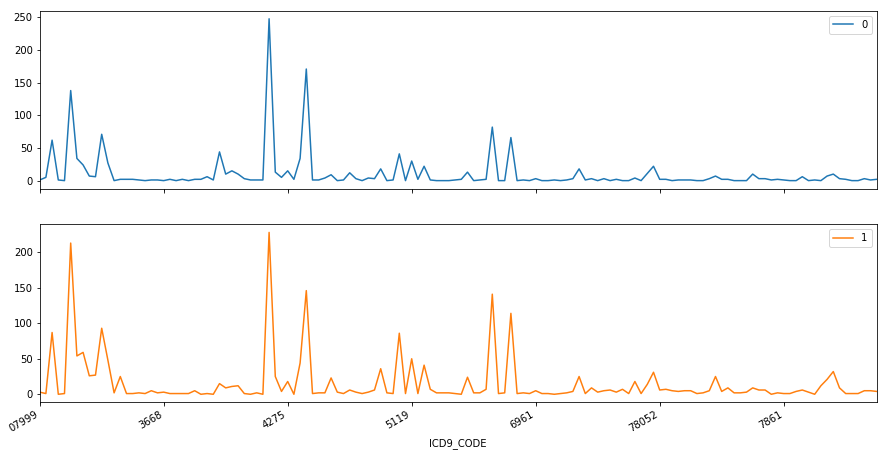

In [19]:
data=repre_128_onedrug.iloc[:,1:]
n_clusters = 2
model_plot(labels=runKMeans(data,n_clusters),plotrows=2,n_clusters=n_clusters)

Counter({3: 484, 2: 305, 1: 254, 0: 240})
(2, 2)


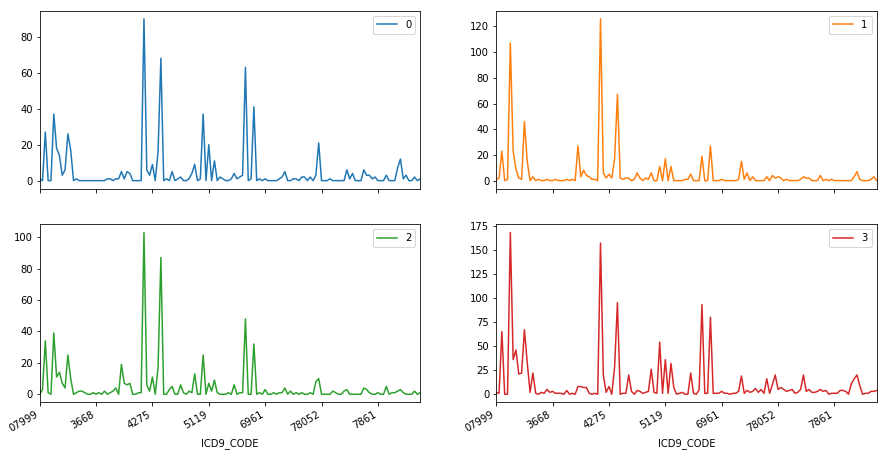

In [101]:
data=repre_128_onedrug.iloc[:,1:]
n_clusters = 4
model_plot(labels=runKMeans(data,n_clusters),plotrows=2,n_clusters=n_clusters)

Counter({0: 320, 1: 223, 3: 211, 4: 202, 5: 174, 2: 153})


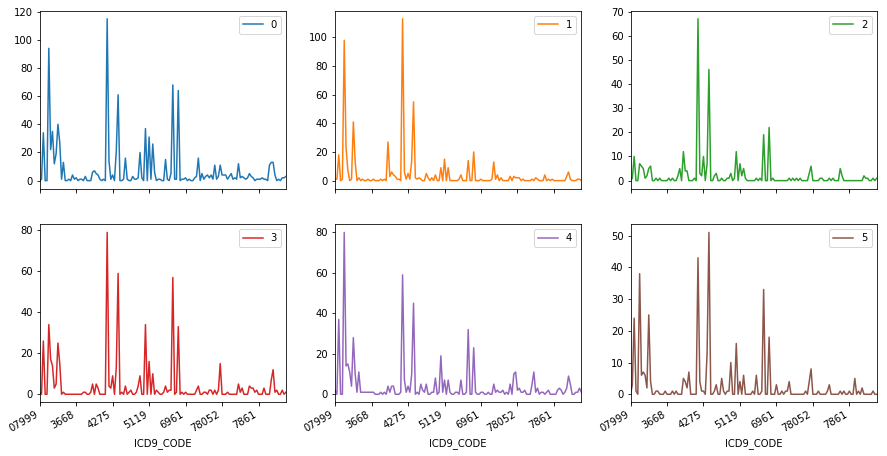

In [79]:
data=repre_128_onedrug.iloc[:,1:]
n_clusters = 6
model_plot(labels=runKMeans(data,n_clusters),plotrows=2)

Counter({2: 290, 4: 190, 6: 158, 1: 155, 3: 131, 0: 127, 7: 127, 5: 105})
(4, 2)


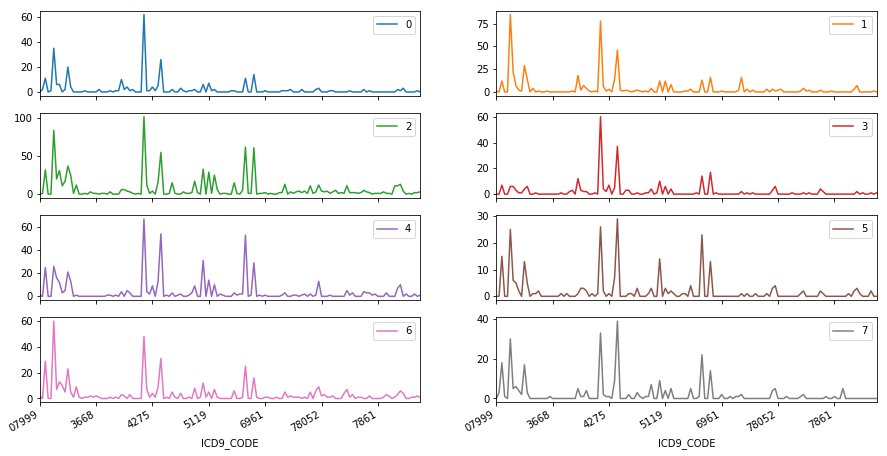

In [43]:
data=repre_128_onedrug.iloc[:,1:]
n_clusters = 8
model_plot(labels=runKMeans(data,n_clusters),n_clusters=n_clusters,plotrows=4)

Counter({0: 807, 1: 476})
(2, 1)


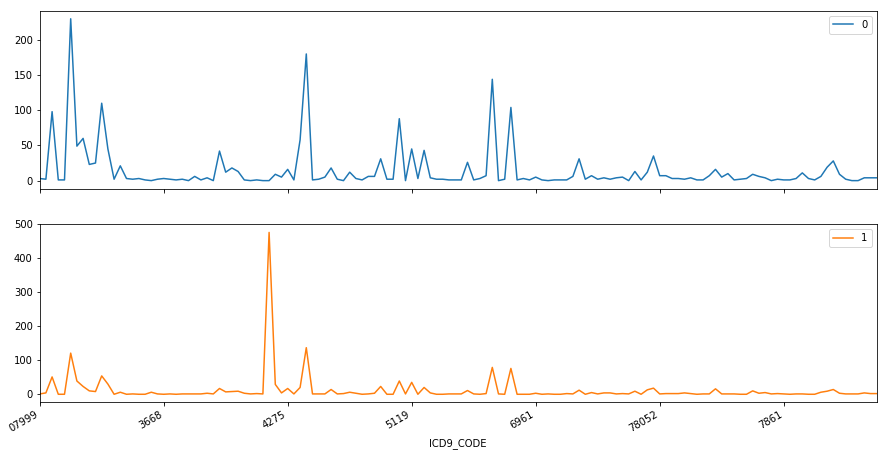

In [20]:
data=patient_diag_matrix
n_clusters = 2
model_plot(labels=runKMeans(data,n_clusters),plotrows=2,n_clusters=n_clusters)

Counter({0: 576, 2: 301, 3: 253, 1: 153})
(2, 2)


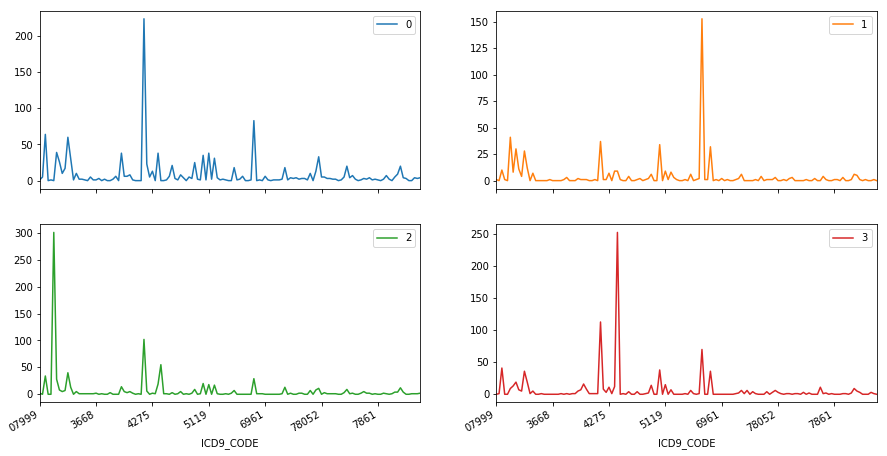

In [102]:
data=patient_diag_matrix
n_clusters = 4
model_plot(labels=runKMeans(data,n_clusters),plotrows=2,n_clusters=n_clusters)

Counter({0: 384, 2: 250, 1: 222, 5: 196, 3: 121, 4: 110})


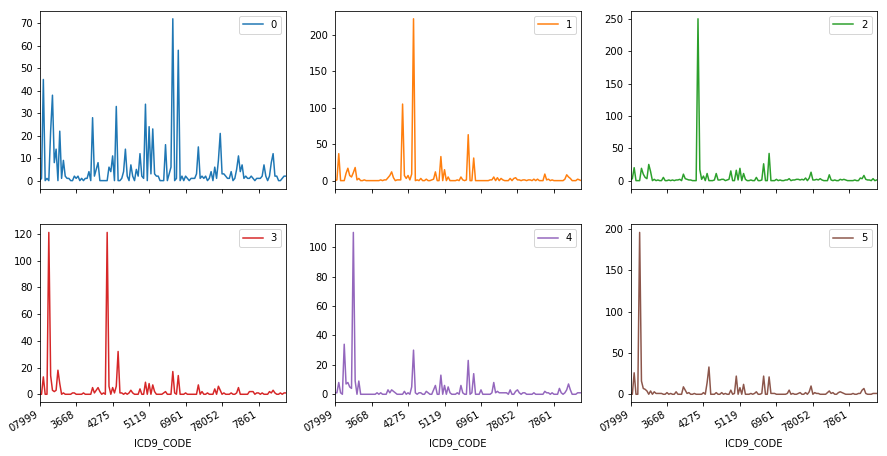

In [81]:
data=patient_diag_matrix
n_clusters = 6
model_plot(labels=runKMeans(data,n_clusters),plotrows=2)

Counter({0: 298, 5: 264, 1: 216, 3: 199, 4: 107, 6: 82, 2: 64, 7: 53})
(4, 2)


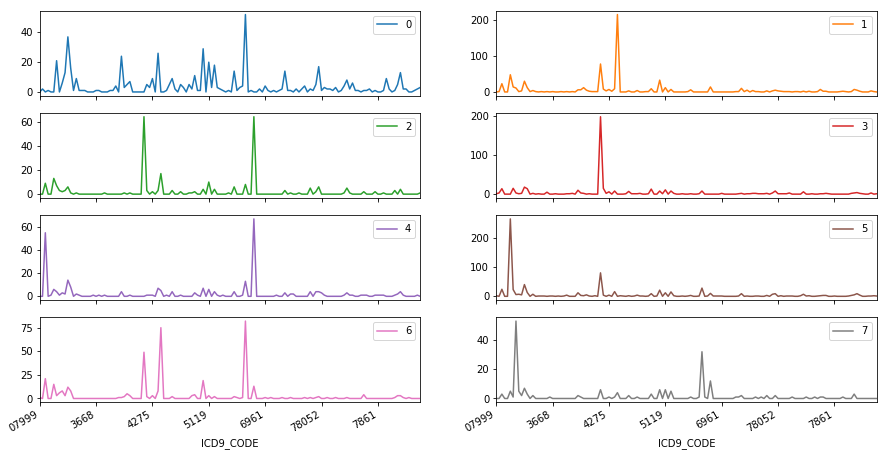

In [42]:
data=patient_diag_matrix
n_clusters = 8
model_plot(labels=runKMeans(data,n_clusters),n_clusters=n_clusters,plotrows=4)

## AffinityPropagation

In [21]:
## affinity propagation clustering algorithm on ADE
from sklearn.cluster import AffinityPropagation
# from sklearn import metrics
from matplotlib import pyplot as plt

In [22]:
def runAP(data,preference=-10000):
    af = AffinityPropagation(preference=preference).fit(data)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_
    n_clusters = len(cluster_centers_indices)
    print("n_clusters: %d"%n_clusters)
    print(Counter(labels))
    return labels, n_clusters

In [35]:
# data=repre_128_onedrug.iloc[:,1:]
# preference = -50
# labels,n_clusters=runAP(data,preference)
# # model_plot(labels=labels,plotrows=6,n_clusters=n_clusters)

n_clusters: 18
Counter({15: 154, 12: 132, 16: 112, 6: 83, 9: 83, 8: 82, 7: 72, 14: 65, 10: 62, 13: 58, 3: 56, 0: 53, 1: 52, 11: 50, 17: 48, 2: 41, 5: 40, 4: 40})
(6, 3)


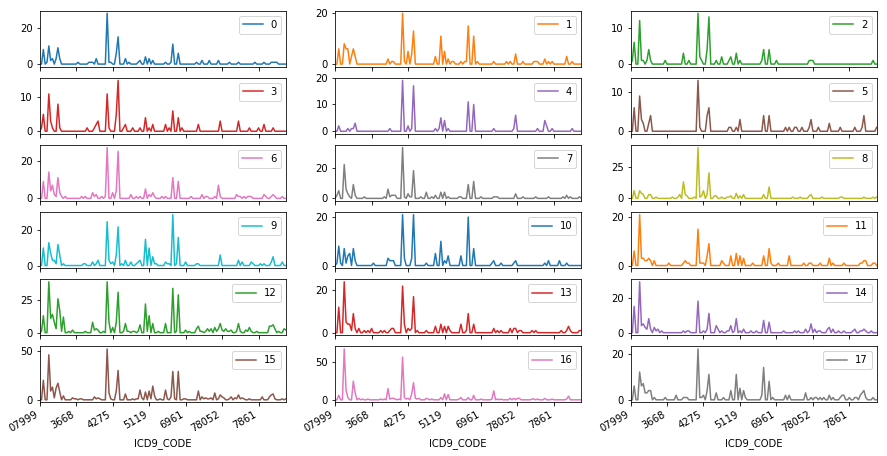

In [103]:
data=repre_128_onedrug.iloc[:,1:]
preference = -20000
labels,n_clusters=runAP(data,preference)
model_plot(labels=labels,plotrows=6,n_clusters=n_clusters)

(5, 2)


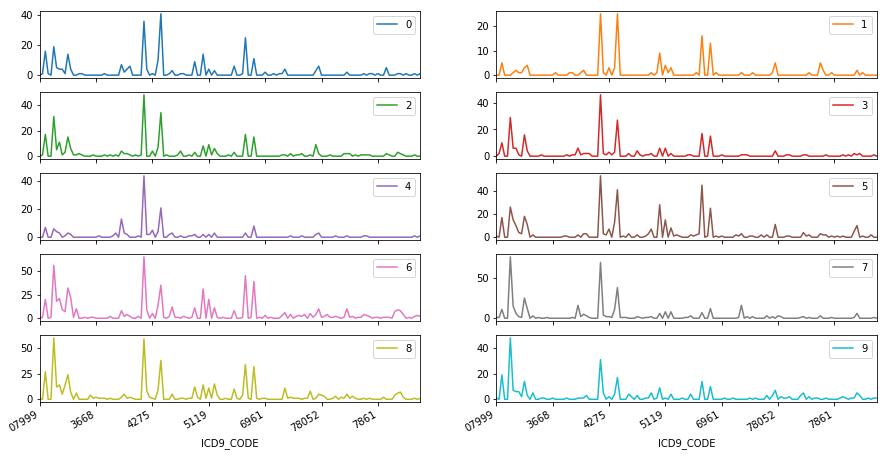

In [27]:
data=repre_128_onedrug.iloc[:,1:]
preference = -30000
labels,n_clusters=runAP(data,preference)
model_plot(labels=labels,plotrows=5,n_clusters=n_clusters)

(6, 2)


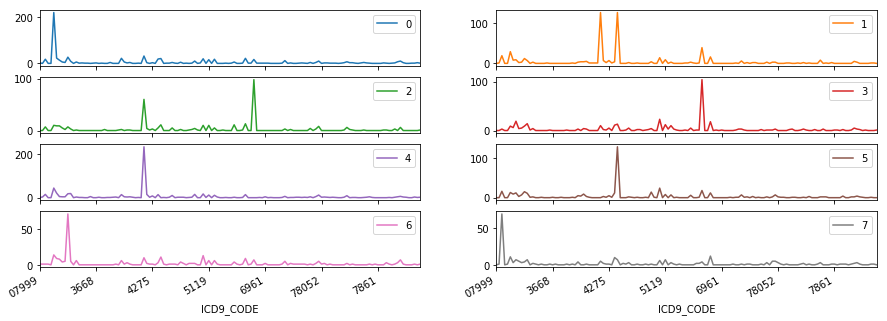

In [32]:
data=patient_diag_matrix
labels,n_clusters=runAP(data,preference=-60)
model_plot(labels=labels,plotrows=6,n_clusters=n_clusters)

n_clusters: 7
Counter({0: 345, 3: 268, 5: 210, 4: 136, 2: 112, 1: 108, 6: 104})
(4, 2)


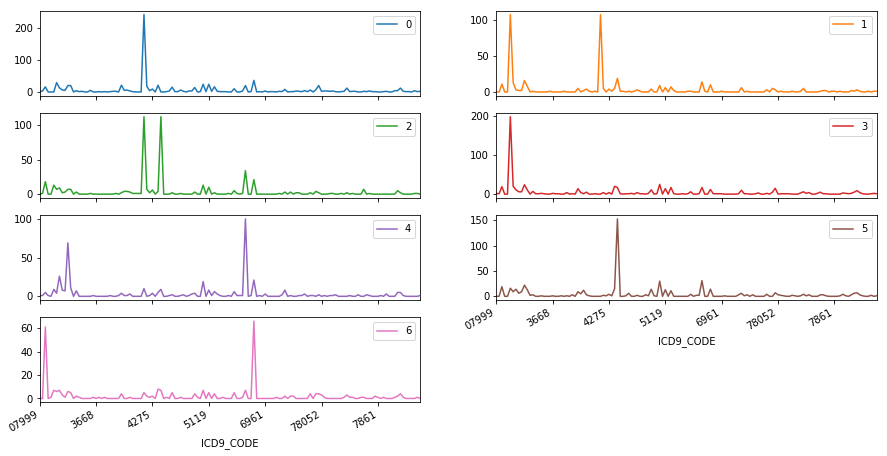

In [40]:
data=patient_diag_matrix
labels,n_clusters=runAP(data,preference=-70)
model_plot(labels=labels,plotrows=4,n_clusters=n_clusters)

## FIND k: DBSCAN

In [106]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

In [110]:
def find_eps(data):
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

In [123]:
def runDBscan(data,eps,min_samples):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    # n_clusters_ = len(cluster_centers_indices)
    # print("n_clusters: %d"%len(dbscan.core_sample_indices_))
    n_clusters=len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
    print(Counter(dbscan.labels_))
    print(n_clusters)
    return dbscan.labels_

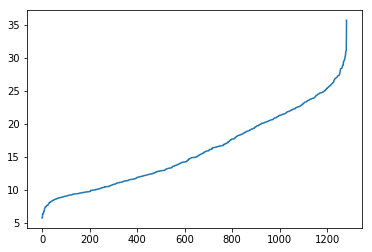

In [121]:
data=repre_128_onedrug.iloc[:,1:]
find_eps(data)

In [124]:
runDBscan(data,28,50)

Counter({-1: 817, 0: 466})
1


array([-1, -1, -1, ...,  0,  0, -1])